In [1]:
from src.grafo import *
from src.log_vqe import *
from src.modelo import *
from src.utils import *
from src.vqe import *

# Optimización de Rutas

El desafío propuesto consiste en optimizar la ruta de una flota para minimizar el consumo de combustible. 

A diferencia de los problemas de optimización puramente teóricos, la logística en una mina a cielo abierto está gobernada por la geometría euclidiana.

## 1. Modelado del Entorno Minero

### 1.1 La Abstracción

Dado que el reto no proporciona un dataset de coordenadas reales, nos enfrentamos a una decisión de diseño para cumplir con el criterio de "setup realista":

**¿Por qué no usar pesos totalmente aleatorios?**
- En un grafo con pesos arbitrarios (ej: $d_{A \to B} = 1$, $d_{B \to C} = 1$, $d_{A \to C} = 100$), se viola frecuentemente la Desigualdad Triangular. 
- En el mundo físico, la distancia directa entre dos puntos nunca puede ser mayor que la suma de un desvío intermedio. Un modelo que viole esto generaría rutas inaceptables para una operación minera real.

**Nuestra Solución**: 
- Hemos optado por generar $N$ nodos distribuidos aleatoriamente en un plano 2D $(x, y)$.
- - Nodos ($i$): Representan los puntos críticos definidos en el problema: Frentes de Carga (Palas), Chancadores, Stocks y Botaderos de Estéril.
- - Aristas ($d_{ij}$): El peso de la conexión entre dos nodos se calcula mediante la distancia euclidiana. Esto simula fielmente el costo de transporte.

### 1.2 Adaptabilidad y Simulación de Bloqueos

El entorno minero es dinámico y hostil. Rutas que hoy son viables pueden quedar inhabilitadas mañana debido a derrumbes, mantenimiento o congestión operativa.

Para demostrar la adaptabilidad de nuestro modelo, hemos implementado un mecanismo de "caminos quebrados" con la penalización mencionada en el reto del hackathon:

$$
d_{ij} = \begin{cases}
\sqrt{(x_i-x_j)^2 + (y_i-y_j)^2}, & \text{si la ruta es viable}\\
\infty, & \text{si la ruta está bloqueada (penalización)}
\end{cases}
$$

En nuestra implementación, asignamos un valor de penalización suficientemente alto (`9999.0`) a las rutas bloqueadas. 

Esto fuerza al Hamiltoniano a elevar drásticamente la energía de cualquier estado que intente usar ese camino, asegurando que la solución cuántica ($E_{min}$) corresponda siempre a una ruta logísticamente válida.

In [2]:
np.random.seed(10)
N = 4

> Bloqueo generado entre Ubicación 0 y 2
> Bloqueo generado entre Ubicación 1 y 2
Grafo generado con 4 ubicaciones.
Ejemplo de distancia (Nodo 0 a Nodo 1): 74.10


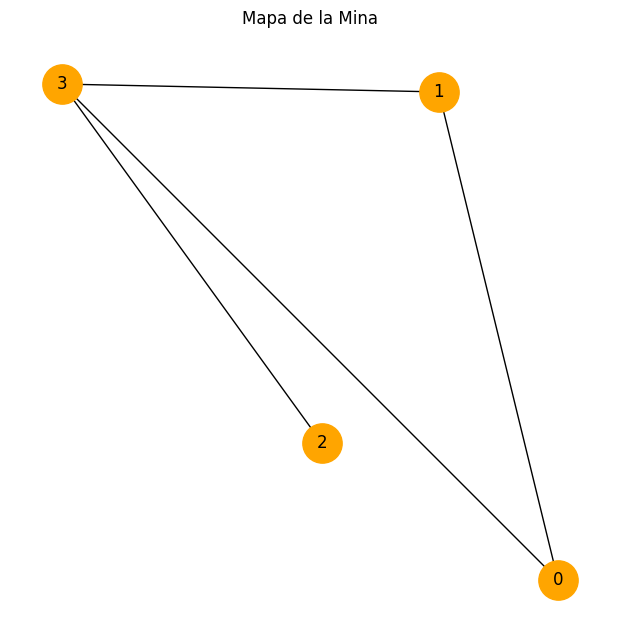

In [3]:
G_mina, matriz_distancias, posiciones = crear_grafo_mina(N, n_bloqueos=2)

print(f"Grafo generado con {N} ubicaciones.")
print("Ejemplo de distancia (Nodo 0 a Nodo 1):", f"{matriz_distancias[0][1]:.2f}")

plot_graph(G_mina, posiciones)

## 2. Formulación del Hamiltoniano

Una vez definido el grafo espacial, debemos traducir el problema de optimización a un Modelo Cuadrático Binario sin Restricciones (QUBO). 

El objetivo es construir un Hamiltoniano $H$ tal que su estado fundamental corresponda a la ruta óptima de la flota.

### 2.1 Definición de Variables

Utilizamos variables binarias $x_{i,t}$ que conectan el espacio físico con la secuencia temporal:

$$
x_{i,t} = \begin{cases} 
1, & \text{si el camión visita la ubicación } i \text{ en el paso temporal } t \\
0, & \text{caso contrario}
\end{cases}
$$

Para un problema con $N$ ubicaciones, requerimos $N^2$ variables (qubits). 

Esto genera una matriz de permutación donde cada fila y cada columna debe sumar exactamente 1.

### 2.2 Restricciones del Sistema

Dado que los algoritmos variacionales, como VQE, buscan minimizar energía, convertimos las restricciones "duras" en términos de penalización energética.

#### A. Unicidad Espacial ($Q_A$)
El camión no puede estar en dos lugares a la vez. Para cada instante $t$, la suma de probabilidades debe ser 1.

$$Q_A = A \sum_{t} \left( 1 - \sum_{i} x_{i,t} \right)^2$$

#### B. Unicidad Temporal ($Q_B$)

Cada punto crítico debe ser visitado exactamente una vez por ciclo.

$$Q_B = A \sum_{i} \left( 1 - \sum_{t} x_{i,t} \right)^2$$

Al expandir estos términos cuadráticos, obtenemos interacciones Ising del tipo $+2Ax_{i,t}x_{j,t}$, lo que penaliza fuertemente (aumenta la energía) si dos qubits están activos simultáneamente en la misma fila o columna.

### 2.3 Función de Costo ($Q_C$)

Buscamos minimizar la distancia total recorrida. 

Este término solo aporta energía si viajamos consecutivamente de la ubicación $i$ a la $j$:

$$Q_C = B \sum_{i,j} d_{ij} \sum_{t} x_{i,t} x_{j,t+1}$$

Donde $d_{ij}$ es la distancia euclidiana (o penalizada por bloqueos) entre nodos.

> Nota sobre la Ciclicidad: En nuestra implementación, el índice temporal $t+1$ es modular ($t+1 \pmod N$). 

> Esto asegura que la ruta sea un ciclo cerrado, requisito indispensable para la operación continua de la flota CAEX (similar a un TSP clásico).

### 2.4 Jerarquía de Energia

Para garantizar que el sistema cuántico priorice la validez de la ruta sobre el ahorro de distancia, debemos configurar la constante de penalización $A$ tal que:

$$A \gg B \cdot \max(d_{ij})$$

Si $A$ fuera muy pequeño, el estado fundamental podría ser una "ruta fantasma" (ej: no visitar ningún nodo) con energía cero. 

Nuestra implementación calcula automáticamente un $A$ seguro baseándose en la matriz de distancias generada.

In [4]:
print("--- Construyendo Hamiltoniano ---")
bqm_mina = crear_hamiltoniano(matriz_distancias, A=None, B=1.0)

num_qubits = len(bqm_mina.variables)
num_interacciones = len(bqm_mina.quadratic)

print(f"Modelo generado exitosamente.")
print(f"Variables (Qubits): {num_qubits} (Para N={len(matriz_distancias)})")
print(f"Acoplamientos (Interacciones): {num_interacciones}")

--- Construyendo Hamiltoniano ---
Constante A calculada automáticamente: 19998.00 (Max dist: 9999.0)
Modelo generado exitosamente.
Variables (Qubits): 16 (Para N=4)
Acoplamientos (Interacciones): 96


In [5]:
qp_mina = bqm_to_qp(bqm_mina)
print(f"Objeto QuadraticProgram creado: {qp_mina.name}")

Objeto QuadraticProgram creado: Optimización de Minería


### 2.4 Verificación del Modelo

Antes de ejecutar el algoritmo cuántico, es prudente verificar matemáticamente que el operador Ising generado tenga sentido físico. 

Para un problema de TSP con $N=4$, esperamos $N^2=16$ qubits.

El operador de Pauli resultante será la entrada para nuestro Variational Quantum Eigensolver (VQE).

In [6]:
hamiltoniano, ansatz, offset = preparar_problema(bqm_mina)

print("\n--- Detalles del Operador de Ising ---")
print(f"Número de Qubits: {hamiltoniano.num_qubits}")
print(f"Número de términos de Pauli (Complejidad de medición): {len(hamiltoniano)}")
print(f"Offset de Energía (Constante): {offset:.4f}")

Problema preparado: 16 Qubits.
Parámetros del Ansatz: 32

--- Detalles del Operador de Ising ---
Número de Qubits: 16
Número de términos de Pauli (Complejidad de medición): 112
Offset de Energía (Constante): 200525.3641


## 4. Ejecutando el VQE

In [7]:
log = LogVQE()
resultado_opt, historial, ansatz_opt, energia_total = run_vqe(bqm_mina, log)

Problema preparado: 16 Qubits.
Parámetros del Ansatz: 32
Iniciando optimización VQE con COBYLA
Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number of function values = 300   Least value of F = -327861.0829843073
The corresponding X is:
[4.32617794 4.70228958 1.39837986 7.49247373 1.57696223 1.56613033
 7.86207762 4.68111535 4.71583893 1.57915204 2.91610286 4.76817155
 4.66651682 1.55105339 4.73211363 1.55908093 4.37184706 1.66992004
 0.95046844 4.58326678 1.58302442 4.60067345 1.63471765 4.69213607
 1.49545353 3.04688322 3.01550504 4.7308541  1.60557302 1.51483872
 7.87832897 1.48780465]


Optimización completada.
Energía mínima encontrada: -127335.7189


## 5. Interpretar Resultados

In [8]:
qp_mina = bqm_to_qp(bqm_mina)
ruta_final, dist_prob = interpretar_solucion(ansatz, resultado_opt.x, qp_mina)
print("Ruta encontrada:", ruta_final)

Estado más probable: 1000001000010100 (Prob: 43.55%)
Ruta encontrada: [1, 2, 0, 3]


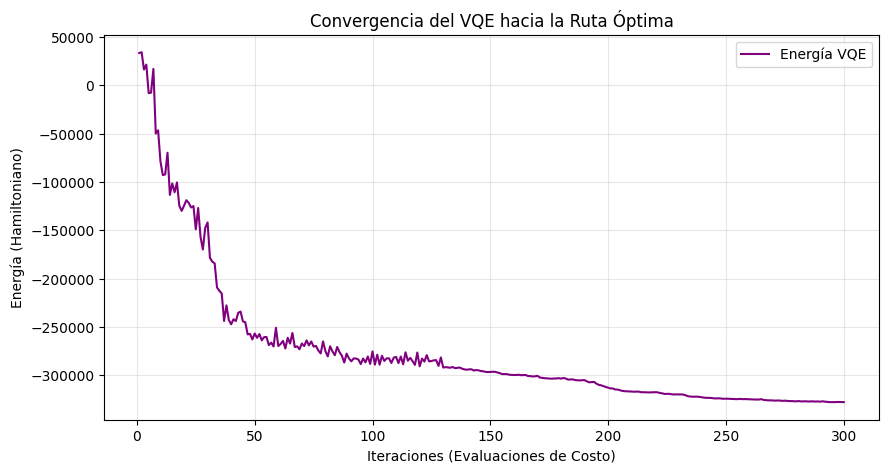

In [9]:
graficar_convergencia(log)

Secuencia de visita: [1, 2, 0, 3] -> 1 (Ciclo)


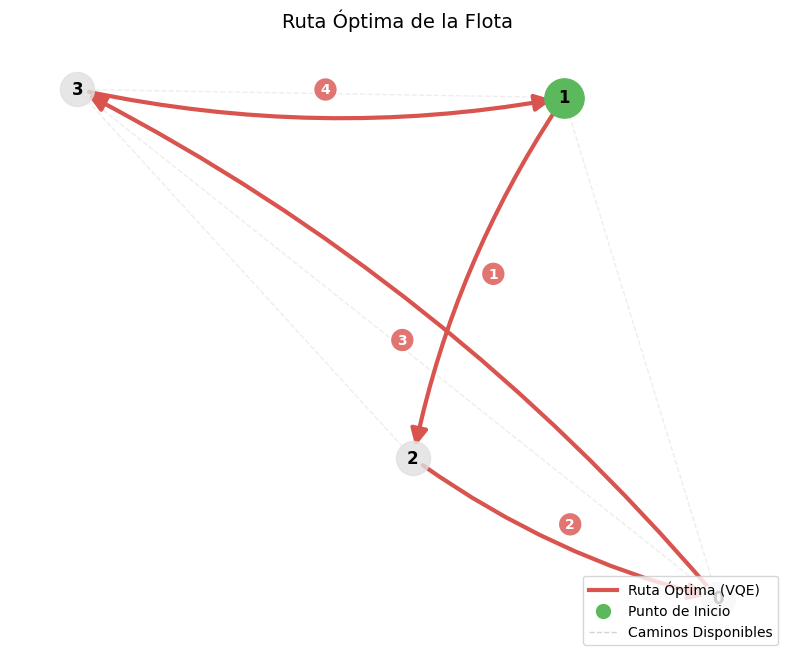

In [10]:
visualizar_ruta_direccionada(G_mina, posiciones, ruta_final)